In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [160]:
# Считаем данные
X = pd.read_csv('forestfires.csv')
y, X = X['area'], X.drop('area', axis=1)

In [161]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


In [162]:
# Добавим свободный коэффициент
free = pd.DataFrame([1.0] * len(X))
X = pd.concat([X, free], axis=1, join_axes=[X.index])
X.columns.values[-1] = 'free'

In [163]:
# Заменим месяц на индикатор лета
X['isSummer'] = [1 if (x[2]=='jun' or x[2]=='jul' or x[2]=='aug') else 0 for x in X.values]
X = X.drop('month', axis=1)

In [164]:
# День не просто дропнем, а заменим на индикатор - воскресенье или понедельник
# (В выходные больше отдыхающих, которые могут не потушить костер)
X['isDayOff'] = [1 if (x[2]=='sun' or x[2]=='mon') else 0 for x in X.values]
X = X.drop('day', axis=1)

In [165]:
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,free,isSummer,isDayOff
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,1.0,0,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,1.0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.0,0,1


Воспользуемся методом наименьших квадратов

$\overline{y} = X\overline{b}$, где b - вектор параметров

$RSS = (\overline{y} - X\overline{b})^T(\overline{y} - X\overline{b})$ - сумма квадратов отстатков, ее нужно минимизировать

Продиффиринцировав по $\overline{b}$ и приравняв к нулю получаем:

$X^TX\overline{b} = X^T\overline{y}$

$\overline{b} = (X^TX)^{-1}X^Ty$

In [166]:
def fitAndPredict(X_train, X_test, y_train):
    X_train = X_train.values
    b = np.dot(
            np.dot(
                np.linalg.matrix_power(np.dot(X_train.transpose(), X_train), -1),
                X_train.transpose()),
            y_train
        )
    return np.dot(X_test, b)
    
def MSE(predictions, real):
    return np.mean((predictions - real) ** 2.0)

In [167]:
def markModel(X, y):
    # Разобьем данные на 2 выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Предскажем значения во второй выборке, построив модель по первой
    predictions = fitAndPredict(X_train, X_test, y_train)
    # Посчитаем среднеквадратичную ошибку
    return MSE(predictions, y_test)

print markModel(X, y)

3958.1824233


Ошибка очень сильно зависит от разбиения:

In [174]:
error = [markModel(X, y) for i in range(0, 100)]
print np.min(error), np.max(error)

415.995363661 12074.0579117


Сделаем для area преобразование $f(x) = ln(c + x)$ и оценим качество модели для разных c

In [175]:
def markModelLog(X, y, c):
    y = np.log(c + y)
    # Разобьем данные на 2 выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Предскажем значения во второй выборке, построив модель по первой
    predictions = fitAndPredict(X_train, X_test, y_train)
    # Посчитаем среднеквадратичную ошибку (сделав обратное преобразование)
    return MSE(np.exp(predictions) - c, np.exp(y_test) - c)

In [178]:
cValue = np.arange(0.1, 100, 0.1)
minErr = np.array([1e10] * len(cValue))
maxErr = np.array([0] * len(cValue))
meanErr = np.array([0] * len(cValue))
# Проверим c от 0.1 до 100 с шагом 0.1, разбивая данные 10 раз
for i in range(0, len(cValue)):
    c = cValue[i]
    for split in range(0, 10):
        t = markModelLog(X, y, c)
        meanErr[i] += t
        minErr[i] = min(minErr[i], t)
        maxErr[i] = max(maxErr[i], t)
    meanErr[i] /= 10

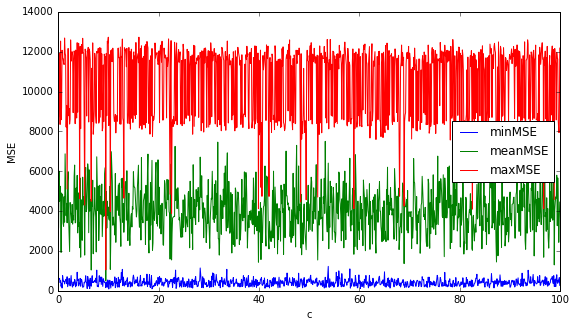

In [179]:
# Построим график
plt.figure(figsize=(9, 5))
plt.plot(cValue, minErr, label='minMSE')
plt.plot(cValue, meanErr, label='meanMSE')
plt.plot(cValue, maxErr, label='maxMSE')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

По графику видно, что качество модели очень сильно зависит от разбиения, поэтому доверять полученым результатам нельзя, конечно лучшее значение c найти можно (для конкретного разбиения), но смысла в этом нет, т.к. для другого разбиения это значение вряд ли подойдет. Так же понятно почему результат так сильно зависит от разбиения - данные даны в порядке возрастания времени, а перемешивая их мы перемешиваем и время (в результате получая данные на случайном расстоянии по времени от тех, по которым надо сделать предсказание), в результате модель переобучается.

In [180]:
def findBestC(X, y):
    # Разобьем данные на 2 выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Найдем лучшее c для данного разбиения
    cValue = np.arange(0.1, 300, 0.1)
    err = np.array([1e10] * len(cValue))
    for i in range(0, len(cValue)):
        c = cValue[i]
        # Предскажем значения во второй выборке, построив модель по первой
        predictions = fitAndPredict(X_train, X_test, np.log(c + y_train))
        err[i] = MSE(np.exp(predictions) - c, y_test)
    plt.figure(figsize=(9, 5))
    plt.plot(cValue, err, label='MSE')
    plt.xlabel('c')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.show()
    print "Best C: ", cValue[np.argmin(err)]

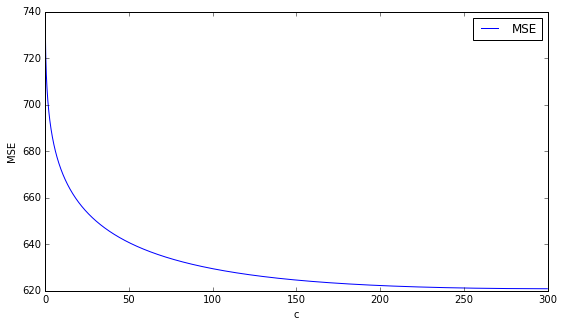

Best C:  299.9


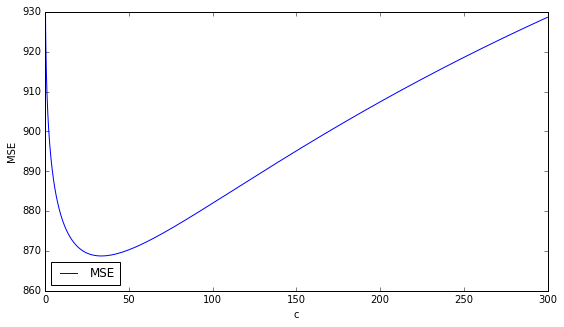

Best C:  33.4


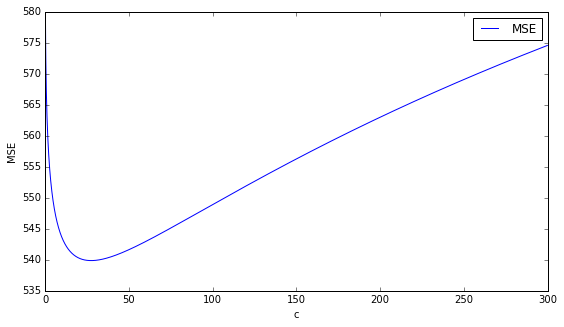

Best C:  27.4


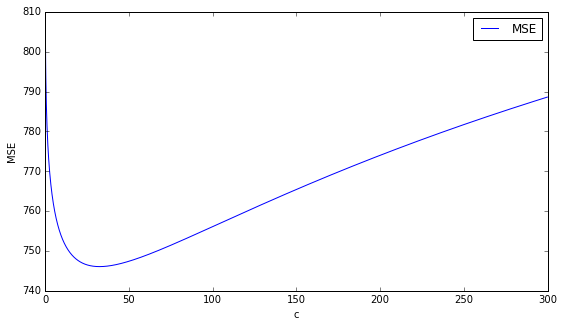

Best C:  32.4


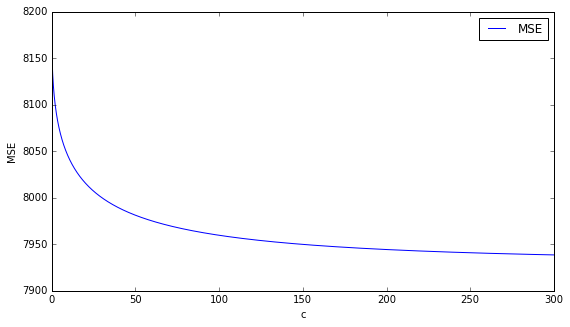

Best C:  299.9


In [201]:
for i in range(0, 5):
    findBestC(X, y)

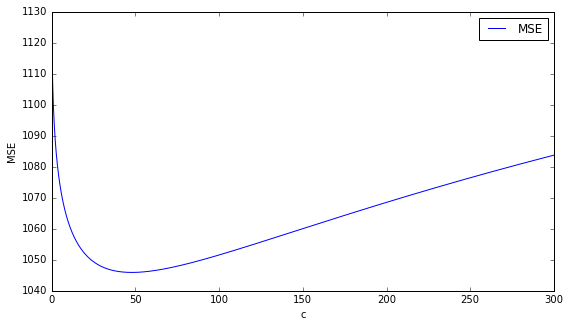

Best C:  47.9


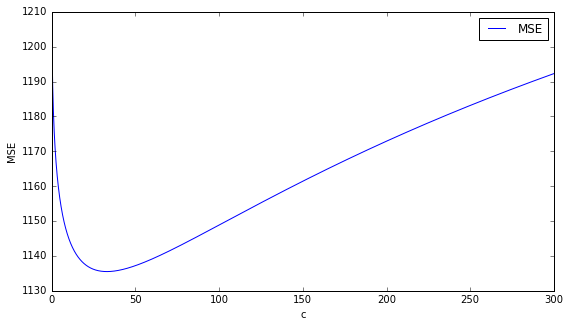

Best C:  33.0


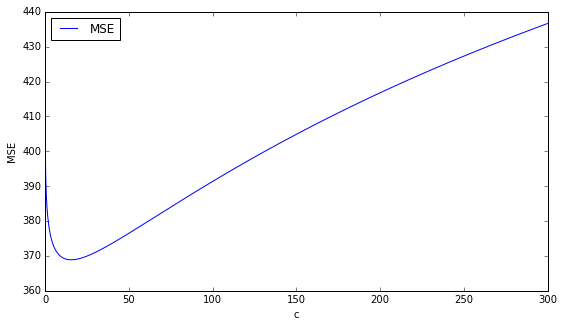

Best C:  15.4


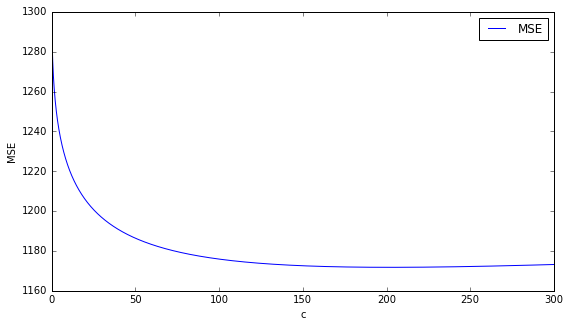

Best C:  202.4


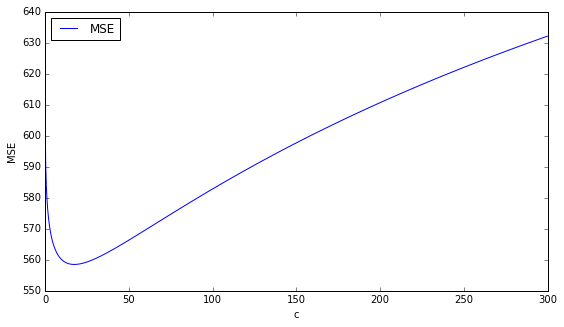

Best C:  17.3


In [202]:
for i in range(0, 5):
    findBestC(X, y)

Из графиков видно, что лучшее значение сильно зависит от разбиения, в целом у годных разбиений c от 15 до 30